In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers, models

In [9]:
train_aa = "/content/drive/MyDrive/FruitinAmazon/train"
test_aa = "/content/drive/MyDrive/FruitinAmazon/test"

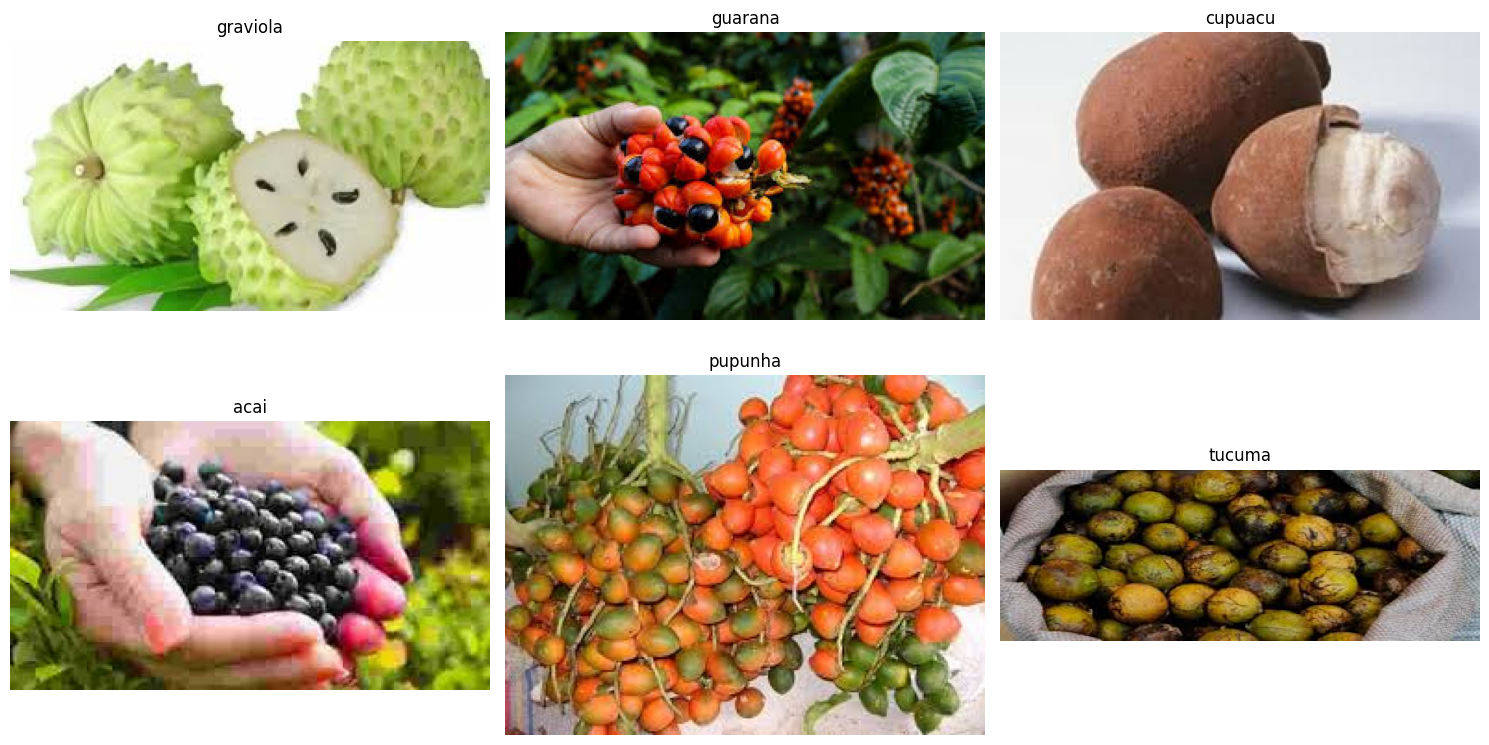

In [27]:
def load_and_visualize_images(train_dir):

    selected_images = []
    class_labels = []
    for class_dir in [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]:
        class_path = os.path.join(train_dir, class_dir)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        if images:
            random_image = random.choice(images)
            selected_images.append(os.path.join(class_path, random_image))
            class_labels.append(class_dir)

    num_images = len(selected_images)
    cols = (num_images + 1) // 2

    fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(15, 8))
    axes = axes.flatten()

    for i, img_path in enumerate(selected_images):
        image = Image.open(img_path)
        axes[i].imshow(image)
        axes[i].set_title(class_labels[i])
        axes[i].axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


load_and_visualize_images(train_aa)

What did you Observe?

Ans: It picks random images from different folders in train_aa, and displays them with labels.

In [11]:
def check_and_remove_corrupted_images(train_dir):
    corrupted_images = []

    for class_dir in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_dir)
        if not os.path.isdir(class_path):
            continue

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")

    if not corrupted_images:
        print("No corrupted images found.")

check_and_remove_corrupted_images(train_aa)

No corrupted images found.


In [31]:
import tensorflow as tf

# Define image size and batch size
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2

# Create a normalization layer
rescale = tf.keras.layers.Rescaling(1./255)

# Create training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_aa,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Apply normalization
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

# Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_aa,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

# Apply normalization
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(os.listdir(train_aa)), activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=250, batch_size=16, callbacks=callbacks)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.1597 - loss: 1.8224

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step - accuracy: 0.1615 - loss: 1.8242 - val_accuracy: 0.1667 - val_loss: 1.6584
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5324 - loss: 1.6077

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step - accuracy: 0.5174 - loss: 1.6047 - val_accuracy: 0.7222 - val_loss: 1.2923
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5550 - loss: 1.3745

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - accuracy: 0.5551 - loss: 1.3590 - val_accuracy: 0.6111 - val_loss: 1.2123
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.6753 - loss: 1.0131

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - accuracy: 0.6732 - loss: 1.0006 - val_accuracy: 0.6667 - val_loss: 1.0355
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.7297 - loss: 0.7377

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - accuracy: 0.7313 - loss: 0.7363 - val_accuracy: 0.7222 - val_loss: 0.6258
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - accuracy: 0.8364 - loss: 0.6086 - val_accuracy: 0.8333 - val_loss: 0.6559
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.8513 - loss: 0.4123

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.8433 - loss: 0.4240 - val_accuracy: 0.8889 - val_loss: 0.4424
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - accuracy: 0.9410 - loss: 0.3247 - val_accuracy: 0.6667 - val_loss: 0.7064
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9300 - loss: 0.2847

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - accuracy: 0.9301 - loss: 0.2846 - val_accuracy: 0.8333 - val_loss: 0.4090
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9601 - loss: 0.1986

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step - accuracy: 0.9596 - loss: 0.1994 - val_accuracy: 0.8889 - val_loss: 0.3300
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 1.0000 - loss: 0.0943 - val_accuracy: 0.8333 - val_loss: 0.5955
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9902 - loss: 0.0847

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step - accuracy: 0.9891 - loss: 0.0851 - val_accuracy: 0.8333 - val_loss: 0.3118
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 1.0000 - loss: 0.0366

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - accuracy: 1.0000 - loss: 0.0357 - val_accuracy: 0.9444 - val_loss: 0.2409
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - accuracy: 1.0000 - loss: 0.0277 - val_accuracy: 0.8333 - val_loss: 0.2413
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - accuracy: 1.0000 - loss: 0.0171 - val_accuracy: 0.8333 - val_loss: 0.3801
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 0.8333 - val_loss: 0.3514
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.8333 - val_loss: 0.3327
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.8333 - val_loss: 0.3261


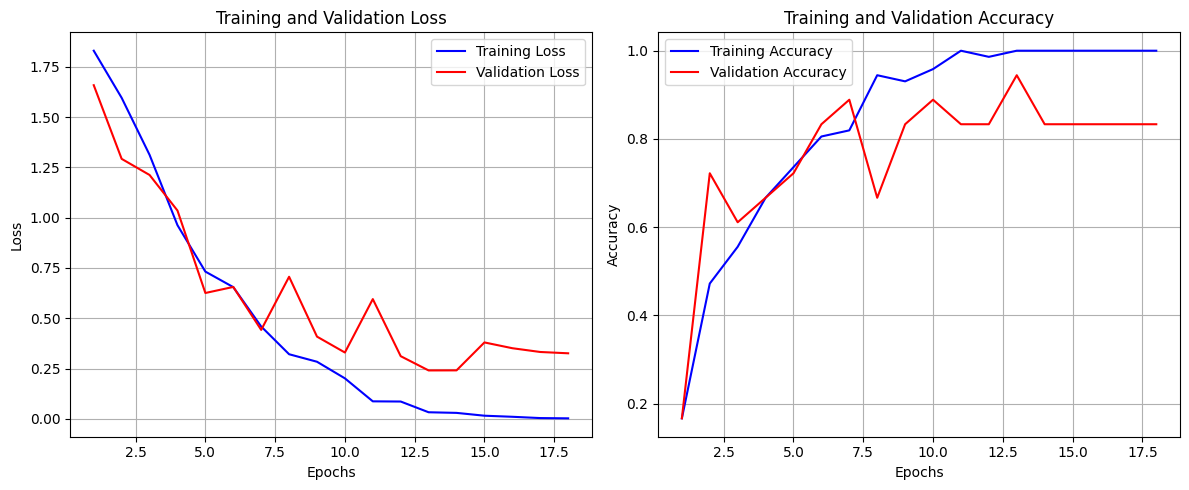

In [34]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [38]:
model.save('fruitdetection.h5')
loaded_model = keras.models.load_model('fruitdetection.h5')

print('model saved to fruitdetection.h5')
print('model loaded from fruitdetection.h5')

model saved to fruitdetection.h5
model loaded from fruitdetection.h5


In [51]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.metrics import classification_report

loaded_model = keras.models.load_model('fruitdetection.h5')
print("Model loaded for predictions")

img_height, img_width = 128, 128
batch_size = 32

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_aa,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

all_images = []
all_labels = []
for images, labels in test_dataset:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

test_images = np.concatenate(all_images, axis=0)
test_labels_onehot = np.concatenate(all_labels, axis=0)

predictions = loaded_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)

class_names = test_dataset.class_names
print(f"Class names: {class_names}")

report = classification_report(true_labels, predicted_labels, target_names=class_names, zero_division=1)
print("Classification Report:\n", report)

Model loaded for predictions
Found 30 files belonging to 6 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Classification Report:
               precision    recall  f1-score   support

        acai       1.00      0.00      0.00         5
     cupuacu       1.00      0.00      0.00         5
    graviola       0.19      1.00      0.32         5
     guarana       1.00      0.00      0.00         5
     pupunha       0.75      0.60      0.67         5
      tucuma       1.00      0.00      0.00         5

    accuracy                           0.27        30
   macro avg       0.82      0.27      0.16        30
weighted avg       0.82      0.27      0.16        30

